In [2]:
# Library & prepare training, testing data
library(caret)
library(randomForest)
colClasses=c("integer", "factor", "integer", "factor", "integer", "factor", "factor", "factor", "factor", "factor",
             "integer", "integer", "integer", "factor", "factor")

url_train <- "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
data_train <- read.table( file=url_train, header=FALSE, colClasses=colClasses, sep=",", strip.white=TRUE )

url_test <- "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
data_test <- read.table( file=url_test, skip=1, header=FALSE, colClasses=colClasses, sep=",", strip.white=TRUE)

#remove trailing dot
data_test[,15] <- factor(sub("\\.", "", data_test[,15]))

# inTrain <- createDataPartition(y=data_train$V15, p=0.7, list=FALSE)
# training <- data_train[inTrain,]
# validation <- data_train[-inTrain,]


Warning message:
"package 'caret' was built under R version 3.4.3"Loading required package: lattice
Warning message:
"package 'lattice' was built under R version 3.4.3"Warning message:
"package 'randomForest' was built under R version 3.4.3"randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:ggplot2':

    margin



In [5]:
common <- intersect(names(data_train), names(data_test)) 
for (p in common) { 
  if (class(data_train[[p]]) == "factor") { 
    levels(data_test[[p]]) <- levels(data_train[[p]]) 
  } 
}
head(data_train,5)
head(data_test,5)


V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15
39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15
25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,Trinadad&Tobago,<=50K
38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,Trinadad&Tobago,<=50K
28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,Trinadad&Tobago,>50K
44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,Trinadad&Tobago,>50K
18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,Trinadad&Tobago,<=50K


In [7]:
# Establish a list of possible values for mtry, nodesize and sampsize
mtry <- seq(2, ncol(data_train) * 0.8, 2)
nodesize <- seq(1, 8, 2)
sampsize <- nrow(data_train) * c(0.7, 0.8, 1)

# Create a data frame containing all combinations 
hyper_grid <- expand.grid(mtry = mtry, nodesize = nodesize, sampsize = sampsize)

# Create an empty vector to store OOB error values
oob_err <- c()

# Write a loop over the rows of hyper_grid to train the grid of models
for (i in 1:nrow(hyper_grid)) {

    # Train a Random Forest model
    model <- randomForest(x=data_train[,1:14],
                          y=data_train[,15],
                          mtry = hyper_grid$mtry[i],
                          nodesize = hyper_grid$nodesize[i],
                          sampsize = hyper_grid$sampsize[i])
                          
    # Store OOB error for the model                      
    oob_err[i] <- model$err.rate[nrow(model$err.rate), "OOB"]
}

# Identify optimal set of hyperparmeters based on OOB error
opt_i <- which.min(oob_err)
print(hyper_grid[opt_i,])



   mtry nodesize sampsize
49    2        1    32561


In [10]:
set.seed(1234)
model <- randomForest(x=data_train[,1:14],
                      y=data_train[,15],
                      mtry = 2,
                      nodesize = 1,
                      sampsize = 32561)
model
# Predicting response variable
p <- predict(model ,data_test)
confusionMatrix(p, data_test$V15)




Call:
 randomForest(x = data_train[, 1:14], y = data_train[, 15], mtry = 2,      sampsize = 32561, nodesize = 1) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 17.21%
Confusion matrix:
      <=50K >50K class.error
<=50K 24612  108 0.004368932
>50K   5495 2346 0.700803469

Confusion Matrix and Statistics

          Reference
Prediction <=50K  >50K
     <=50K 12399  2740
     >50K     36  1106
                                          
               Accuracy : 0.8295          
                 95% CI : (0.8236, 0.8352)
    No Information Rate : 0.7638          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.376           
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9971          
            Specificity : 0.2876          
         Pos Pred Value : 0.8190          
         Neg Pred Value : 0.9685          
             Prevalence : 0.7638          
         Detection Rate : 0.7616          
   Detection Prevalence : 0.9299          
      Balanced Accuracy : 0.6423          
                                          
       'Positive' Class : <=50K           
                                          

In [6]:
model <- randomForest(x=data_train[,1:14],
                      y=data_train[,15],
                      mtry = 9,
                      nodesize = 5)
model

# Predicting response variable
p <- predict(model ,data_test)
confusionMatrix(p, data_test$V15)


Call:
 randomForest(x = data_train[, 1:14], y = data_train[, 15], mtry = 9,      nodesize = 5) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 9

        OOB estimate of  error rate: 17.62%
Confusion matrix:
      <=50K >50K class.error
<=50K 24609  111 0.004490291
>50K   5627 2214 0.717638056

Confusion Matrix and Statistics

          Reference
Prediction <=50K  >50K
     <=50K 12377  2793
     >50K     58  1053
                                         
               Accuracy : 0.8249         
                 95% CI : (0.819, 0.8307)
    No Information Rate : 0.7638         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.3567         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.9953         
            Specificity : 0.2738         
         Pos Pred Value : 0.8159         
         Neg Pred Value : 0.9478         
             Prevalence : 0.7638         
         Detection Rate : 0.7602         
   Detection Prevalence : 0.9318         
      Balanced Accuracy : 0.6346         
                                         
       'Positive' Class : <=50K          
                                         

mtry = 3  OOB error = 17.52% 
Searching left ...
mtry = 2 	OOB error = 16.96% 
0.03207713 0.01 
Searching right ...
mtry = 4 	OOB error = 17.57% 
-0.03603767 0.01 


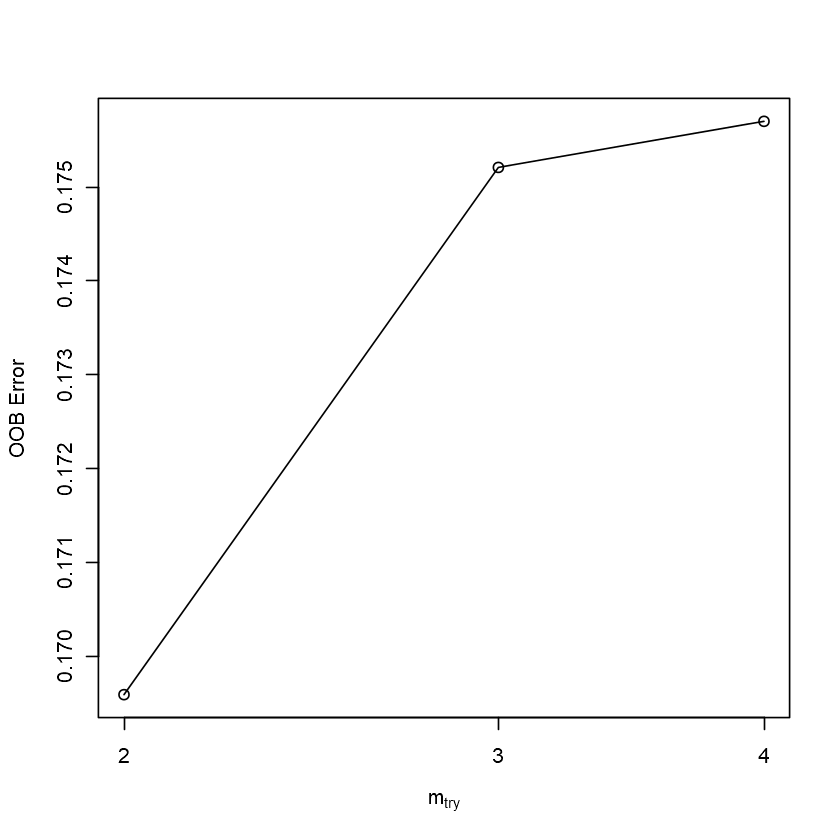

In [3]:
library(ggplot2)
bestmtry <- tuneRF(data_train[-15],data_train$V15, ntreeTry=500, 
     stepFactor=1.5,improve=0.01, trace=TRUE, dobest=FALSE)


In [24]:
bestmtry
adult.rf <-randomForest(V15~.,data=data_train, mtry=2, ntree=1000, 
     keep.forest=TRUE, importance=TRUE,test=data_test)

,mtry,OOBError
2.OOB,2,0.1732441
3.OOB,3,0.1762231
4.OOB,4,0.1760388


In [25]:
adult.rf


Call:
 randomForest(formula = V15 ~ ., data = data_train, mtry = 2,      ntree = 1000, keep.forest = TRUE, importance = TRUE, test = data_test) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 2

        OOB estimate of  error rate: 17.2%
Confusion matrix:
        <=50K  >50K class.error
 <=50K  24608   112 0.004530744
 >50K    5488  2353 0.699910726